### Shoe sales forecast

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf,pacf,acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import os
from matplotlib import dates
import warnings
warnings.filterwarnings('ignore')
import math
from prettytable import PrettyTable
from tqdm import tqdm
from datetime import datetime

In [2]:
# Importing data set
data=pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name="Raw Data")

In [3]:
# Chekcing head and tail details
data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,M_Y
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California,9_2017
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California,9_2017
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California,9_2017
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky,9_2017
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island,9_2017


In [4]:
data.tail()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,M_Y
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565.0,220,2018-12-26,8.0,Oregon,2_2019
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598.0,220,2018-12-26,8.5,California,2_2019
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605.0,220,2018-12-26,5.5,New York,2_2019
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650.0,220,2018-12-26,11.0,California,2_2019
99955,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,640.0,220,2018-12-26,11.5,Texas,2_2019


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 9 columns):
Order Date      99956 non-null datetime64[ns]
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null float64
Retail Price    99956 non-null int64
Release Date    99956 non-null datetime64[ns]
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
M_Y             99956 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 6.9+ MB


This shows that there are no missing values in data

In [6]:
# Checking unique values
buyer_regions = list(data['Buyer Region'].unique())
buyer_regions.sort()
brand = list(data['Brand'].unique())
brand.sort()
shoe_size = list(data['Shoe Size'].unique())
shoe_size.sort()
print("Total buyer region: ",len(buyer_regions),'\n',buyer_regions)
print("Total brand",len(brand),'\n',brand)
print("Total shoe sizes in data: ",len(shoe_size),'\n',shoe_size)

Total buyer region:  51 
 ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Total brand 2 
 ['Off-White', 'Yeezy']
Total shoe sizes in data:  26 
 [3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 16.0, 17.0]


In [7]:
# Brand wise bifurcation
data_yeezy = data[data.Brand == 'Yeezy']
data_offwhite = data[data.Brand == 'Off-White']

In [8]:
## getting data into shape and groupping it into Brand wise for shoe sizes and region wise

# for yeezy brand
yeezy_ss_data = pd.DataFrame()
for i in shoe_size:
    temp = data_yeezy[data_yeezy['Shoe Size']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        yeezy_ss_data[i] = temp
        

# for offwite brand
offwhite_ss_data = pd.DataFrame()
for i in shoe_size:
    temp = data_offwhite[data_offwhite['Shoe Size']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        offwhite_ss_data[i] = temp


# Replacing all the NaN values with 0
yeezy_ss_data.fillna(0, inplace=True)
offwhite_ss_data.fillna(0, inplace=True)


print("Yeezy shoe size consistent data for sizes: ",len(yeezy_ss_data.columns) ,yeezy_ss_data.columns)
print("off-white shoe size consistent data for sizes: ",len(offwhite_ss_data.columns),offwhite_ss_data.columns)
#y_7_5 = data_yeezy[data_yeezy['Shoe Size']==7.5].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]

Yeezy shoe size consistent data for sizes:  23 Float64Index([ 4.0,  4.5,  5.0,  5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,
               9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5,
              16.0],
             dtype='float64')
off-white shoe size consistent data for sizes:  21 Float64Index([ 4.0,  4.5,  5.0,  5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,
               9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 14.0, 15.0],
             dtype='float64')


out of 26 shoe sizes data is only consistent of 23 sizes in yeezy and 21 sizes in off-white brand.

In [9]:
# brand wise and region wise
# for yeezy brand
yeezy_br_data = pd.DataFrame()
for i in buyer_regions:
    temp = data_yeezy[data_yeezy['Buyer Region']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        yeezy_br_data[i] = temp
        

# for offwite brand
offwhite_br_data = pd.DataFrame()
for i in buyer_regions:
    temp = data_offwhite[data_offwhite['Buyer Region']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        offwhite_br_data[i] = temp


# Replacing all the NaN values with 0
yeezy_br_data.fillna(0, inplace=True)
offwhite_br_data.fillna(0, inplace=True)


print("Yeezy buyer region consistent data regions: ",len(yeezy_br_data.columns),yeezy_br_data.columns)

print("off-white buyer region consistent data regions: ",len(offwhite_br_data.columns),offwhite_br_data.columns)


Yeezy buyer region consistent data regions:  51 Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')
off-white buyer region consistent data regions:  42 Index(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Hawaii

Out of 51 region data is consistent in 51 and 42 regions only as mentioned above for both the brands

### Helper Functions

In [10]:
def prediction_interval(residual,forecast,alpha,z=1.96,lead_time=1):
    V_th_t=[]
    sigma_2=np.var(residual)
    for h in np.arange(1,lead_time+1):
        temp=sigma_2*(1+(alpha**2)*(h-1))
        V_th_t.append(temp)
    high=forecast+z*np.sqrt(V_th_t)
    low=forecast-z*np.sqrt(V_th_t)
    return(high,low)

In [11]:
def plot_acf_pacf(x,lags=None):
    f, (ax1, ax2) = plt.subplots(1, 2)
    plot_acf(x,ax=ax1,lags=lags);
    plot_pacf(x,ax=ax2,lags=lags)
    ax1.grid()
    ax2.grid()
    f.set_figheight(5)
    f.set_figwidth(15)
    f.text(0.5, 0.04, 'Lags', ha='center')
    f.text(0.08, 0.5, 'Co-relation', va='center', rotation='vertical')

In [12]:
def plot_acf_pacf(x,lags=None):
    f, (ax1, ax2) = plt.subplots(1, 2)
    plot_acf(x,ax=ax1,lags=lags);
    plot_pacf(x,ax=ax2,lags=lags)
    ax1.grid()
    ax2.grid()
    f.set_figheight(5)
    f.set_figwidth(15)
    f.text(0.5, 0.04, 'Lags', ha='center')
    f.text(0.08, 0.5, 'Co-relation', va='center', rotation='vertical')

In [13]:
def test_trend_stationarity(x):
    H0="Time series is not stationary"
    H1="Time series is stationary"

    p_value=adfuller(x)[1]
    if(p_value>0.05):
        #print(H0)
        return(False)
    else:
        #print(H1)
        return(True)

In [14]:
from matplotlib import dates as mdates
formatter = dates.DateFormatter('%Y-%m-%d') 
def plot_time_series(x,label=None,marker=None):
    fig ,ax= plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(14)
    plt.plot(x,label=label,marker=marker)
    plt.grid()
    plt.xticks(rotation='45')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1,interval=2))
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.title("Time Series")
    plt.legend()
    plt.show()

In [15]:
def slow_fast(data):
    Obsolescence_SKU=[]
    Fast_Moving_SKU=[]
    Intermittence_SKU=[]
    Dead_SKU=[]
    for k,v in data.iteritems():
            Total_periods=len(v)
            Demand_bucket=np.count_nonzero(v)
            #print(Demand_bucket)
            if(Demand_bucket==0):
                Dead_SKU.append(k)
                continue
            ADI=Total_periods/Demand_bucket
            CV_sq=(np.std(v)/np.mean(v))**2
            

            if(ADI >1.25):
                if(ADI >=12):
                    Obsolescence_SKU.append(k)
                else:
                    Intermittence_SKU.append(k)
            else:
                Fast_Moving_SKU.append(k)
    return(Obsolescence_SKU,Fast_Moving_SKU,Intermittence_SKU,Dead_SKU)
#slow_fast(R5023_Commercial)

In [16]:
def Mean_Squared_Rate(yi,yi_):
    temp1=[]
    for i in range(0,len(yi_)):
        temp2=[]
        for j in range(0,i):
            temp2.append(yi[j])

        ri=yi[i]-((i+1)**-1)*sum(temp2)
        temp1.append(ri)
    MSR=sum(np.array(temp1[:-1])**2)
    print(MSR)
    return(MSR)

In [17]:
def Mean_Absolute_Rate(yi,yi_):
    temp1=[]
    for i in range(0,len(yi_)):
        temp2=[]
        for j in range(0,i):
            temp2.append(yi[j])

        ri=yi[i]-((i+1)**-1)*sum(temp2)
        temp1.append(ri)
    MSR=sum(abs(np.array(temp1[:-1])))
    print(MSR)
    return(MSR)

In [18]:
def Mean_Absolute_Percentage_Error(Actual,Forecasted):
    error=abs((Actual-Forecasted)/Actual)*100
    print(error)
    MAPE=np.round(np.mean(error),2)
    return(MAPE)

In [19]:
def Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample=None):
    n=len(et_in_sample)
    temp1=[]
    for i in range(2,n):
        temp1.append(abs(yt[i]-yt[i-1]))
    MAE_naive_Forecast=sum(temp1)/(n-1)
    MASE_train=np.mean(abs((et_in_sample/MAE_naive_Forecast)[1:]))
    if(et_out_sample is not None):
        MASE_test=np.mean((abs(et_out_sample/MAE_naive_Forecast)[1:]))
        return(MASE_train,MASE_test)
    else:
        return(MASE_train)

In [20]:
def ARIMA_pd(X):
    p=d=q=0
    if(not test_trend_stationarity(X)):
        ACF=acf(np.diff(X))
        PACF=pacf(np.diff(X))
        d=1
    else:
        ACF=acf(X)
        PACF=pacf(X)
        d=0
        
    magnitude=2/np.sqrt(len(X))
    count=0
    for i in range(0,len(X)):
        if(abs(ACF[i])>magnitude):
            count+=1
        else:
            break
    q= count-1
    
    magnitude=2/np.sqrt(len(X))
    count=0
    for i in range(0,len(X)):
        if(abs(PACF[i])>magnitude):
            count+=1
        else:
            break
    p= count-1
    return((p,d,q))

In [21]:
def ARIMA_GridSearch(X,max_pdq=5):
    pdq_new=[]
    aic_score=[]
    import itertools
    p=d=q=range(0,max_pdq)
    pdq = list(itertools.product(p,d,q))
    for param in pdq:
        try:
            model_arima = ARIMA(X,order=param)
            model_arima_fit = model_arima.fit()
            AIC=model_arima_fit.aic
            if(not math.isnan(AIC)):
                    #print(param,AIC)
                    pdq_new.append(param)
                    aic_score.append(np.round(AIC,2))
        except:
            continue
    #print(aic_score)
    return(pdq_new[np.argmin(aic_score)],np.round(min(aic_score),2))

In [22]:
def train_test_split(data,train_size=0.80):
    train_length=int(np.round(len(data)*train_size))
    train=data[:train_length]
    test=data[train_length:]
    return(train,test)

In [23]:
def Forecast_Measures(Demand,Forecast):
    error=Demand-Forecast
    MSE=np.round(sum(error**2)/len(error),2)
    RMSE=np.round(np.sqrt(MSE),2)
    MAE=np.round(sum(abs(error))/len(error),2)
    return(MSE,RMSE,MAE)

In [24]:
dateparse = lambda x: datetime.strptime(x + ' 1', "%Y-W%W %w")

<table style="margin: 0 auto">
    <caption><p>Forecasting Models</p></caption>
    <thead><th><p>Model</p></th><th><p>Types</p></th><th><p>Description</p></th><th><p>Remark</p></th></thead>
  
  <tr>
    <th rowspan="4"><p>1. Exponential smoothing methods</p></th>
    <td><p>A. Single exponential smoothing</p></td>
    <td><p>The method of single exponential forecasting takes the
        forecast for the previous period and adjusts it using the forecast error.</p></td>
	<td rowspan="2">
        <ul>
            <li><p>It was also assumed that the forecast horizon was just one period ahead. For longer range forecasts, it is assumed that the forecast flat forecast function function is “flat.” That is, F t+h = F t+1 ,
h = 2, 3, . . . .
</p></li>
            <li><p>SES assumes the data have no
        underlying trend..</p></li>
        <li><p>Not Suitable for trend and seasonal series.</p></li>
        </ul>
    </td>
  </tr>
  <tr>
    <td><p>B. Single exponential smoothing: an adaptive ap-proach: Two parameter</p></td>
    <td><p>Adaptive-response-rate single exponential smoothing
(ARRSES) may have an advantage over SES in that it allows the adaptive smoothing
value of α to be modified</p></td>
  </tr>
  <tr>
    <td><p>C. Holt’s linear method: suitable for trends</p></td>
    <td><p>Holt (1957) extended single exponential smoothing to linear expo-
nential smoothing to allow forecasting of data with trends.</p></td>
	<td>
        <ul>
            <li><p>Compared with those obtained using single exponential smoothing,Holt’s method outperforms SES on every measurement.</p></li>
            </ul>
    </td>
  </tr>
  
  <tr>
    <td><p>D. Holt-Winters’ trend and seasonality method: suitable for trends and seasonality</p></td>
    <td><p>Holt’s method was extended by Winters to capture seasonality directly.</p></td>
    <td><ul>
            <li><p>Holt’s method, with one additional equation to deal with seasonality.</p></li>
        </ul>
    </td>
  </tr>
  <tr>
    <th rowspan="2"><p>2. Regression methods</p></th>
    <td><p>A. Simple Regression</p></td>
    <td> <ul>
            <li><p>Simple regression refer's to any regression of a single Y variable (the forecast or dependent variable) on a single forecast X variable (the explanatory or independent variable).</p></li>
        </ul>
    </td>
    <td>
        <ul>
                <li><p>Used when Variable to be forecasted can be linearly derived from another single Variable.</p></li>
        </ul>
    <td>
  </tr>
  <tr>
      <td><p>B. Multiple Regression</p></td>
    <td><p>there will be one variable to
forecast (Y ) and several explanatory variables (X 1 , X 2 , . . . , X k ) and the objective will be to find a function that relates Y to all of the explanatory variables.</p></td>
        <td>
            <ul>
                <li><p>Needs multiple factor's to linearly forcast dependent variable.</p></li>
            </ul>
        <td>
  </tr>
  
  <tr>
    <th rowspan="2"><p>3. ARMA Methods:</p></th>
    <td><p>A. AR(p)</p></td>
    <td><p>Auto regression model is model in which a variable to be forecasted is dependent on independent variables which are nothing but time-lagged values of the forecast
        variable.</p></td>
	<td rowspan="2">
        <ul>
            <li><p>Autoregressive (AR) models can be effectively coupled with moving average (MA) models to form a general and useful class of time series models called autoregressive moving average (ARMA) models.</p></li>
            <li><p>The series is assumed stationary in the mean and in the variance.</p></li>
            <li><p>If it is not stationary then differencing must be performed to make series mean stationary.</p></li> 
            <li><p>The order of differencing required to make series mean stationary is denoted by I.</p></li>
        </ul>
    </td>
  </tr>
  <tr>
      <td><p>B. MA(q)</p></td>
      <td><p>Moving Average model which uses past errors as explanatory variables.</p></td>
  </tr>

</table>

## Model selction -

### 1. Shoe Size wise- 

#### 1.1 Yeezy Brand

In [25]:
OS,FS,IS,DS=slow_fast(yeezy_ss_data)
print('No of obsolescence risk shoe sizes data',len(OS))
print('No of Fast Moving shoe sizes data',len(FS))
print('No of Intermittence shoe sizes data',len(IS))
print('No of Dead shoe sizes data',len(DS))

No of obsolescence risk shoe sizes data 0
No of Fast Moving shoe sizes data 23
No of Intermittence shoe sizes data 0
No of Dead shoe sizes data 0


As all shoe sizes data is fast moving hence traditional forecasting methods can be applied to forecast

In [26]:
# Further classification
Fast_stationary=[]
Fast_trend=[]
for i in FS:
    if(test_trend_stationarity(yeezy_ss_data[i])):
        Fast_stationary.append(i)
    else:
        Fast_trend.append(i)

In [27]:
print("Fast Moving shoe_size which are stationary:\n")
for i in np.arange(0,len(Fast_stationary)):
    print("\t\t",i+1,Fast_stationary[i])
print("Fast Moving shoe_size which are non stationary:\n")
for i in np.arange(0,len(Fast_trend)):
    print("\t\t",i+1,Fast_trend[i])

Fast Moving shoe_size which are stationary:

		 1 12.5
Fast Moving shoe_size which are non stationary:

		 1 4.0
		 2 4.5
		 3 5.0
		 4 5.5
		 5 6.0
		 6 6.5
		 7 7.0
		 8 7.5
		 9 8.0
		 10 8.5
		 11 9.0
		 12 9.5
		 13 10.0
		 14 10.5
		 15 11.0
		 16 11.5
		 17 12.0
		 18 13.0
		 19 13.5
		 20 14.0
		 21 14.5
		 22 16.0


###### Fast Moving product

In [28]:
Fast_trend = FS
Fast_trend_product=yeezy_ss_data[Fast_trend[13]]

In [29]:
pt_final= PrettyTable()
pt_final.field_names=['Sr. No.','Demand Pattern','Model','alpha','beta']

In [30]:
from prettytable import PrettyTable
pt_train=PrettyTable()
pt_train.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']
pt_test=PrettyTable()
pt_test.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']

In [31]:
def prediction_interval(residual,forecast,alpha,z=1.96,lead_time=1):
    V_th_t=[]
    sigma_2=np.var(residual)
    for h in np.arange(1,lead_time+1):
        temp=sigma_2*(1+(alpha**2)*(h-1))
        V_th_t.append(temp)
    high=forecast+z*np.sqrt(V_th_t)
    low=forecast-z*np.sqrt(V_th_t)
    return(high,low)

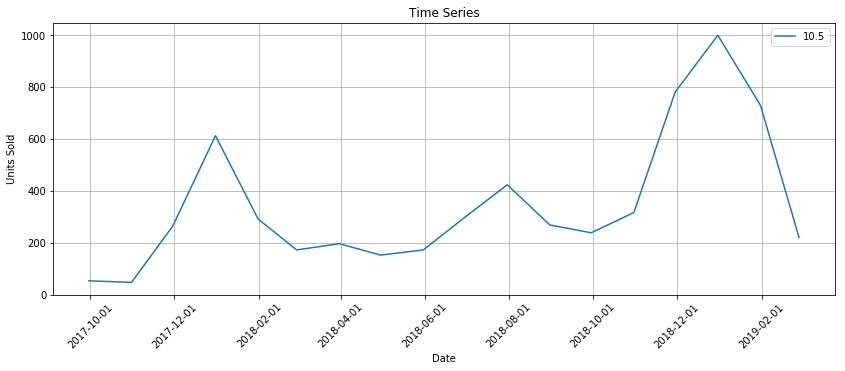

In [32]:
plot_time_series(Fast_trend_product)

In [33]:
train,test=train_test_split(Fast_trend_product)

In [34]:
print("One thing to observe is that entire exhibits trend but when we split the series into train and test set, the train set exhibits no trend:")
print("\t1. Is the Entire Series Stationary?: ",test_trend_stationarity(Fast_trend_product))
print("\t2. Is the Train Series Stationary?: ",test_trend_stationarity(train))

One thing to observe is that entire exhibits trend but when we split the series into train and test set, the train set exhibits no trend:
	1. Is the Entire Series Stationary?:  False
	2. Is the Train Series Stationary?:  False


This shows that data is not stationary. Hence we would apply Fast moving trend methods to all the yeezy_ss_data. Methods are mentioned below :

1. SES
2. Holt's linear
2. ARIMA

#### 1.1.1 SES

In [35]:
import warnings
warnings.filterwarnings('ignore')

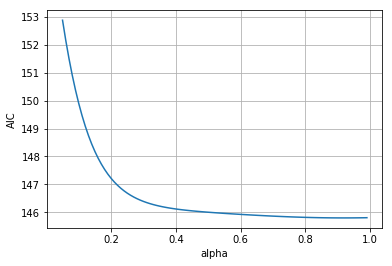

The Least AIC has been achieved for alpha=0.92 with MSE = 145.8


In [36]:
train_aic=[]
alpha_t=np.arange(0.05,1,0.01)
for alpha in alpha_t:
    Model= SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
    #Forecast= Model.forecast(len(test))
    #et=test-Forecast
    #MSE=sum(et**2)/len(et)
    train_aic.append(Model.aic)
plt.plot(alpha_t,train_aic)
plt.xlabel("alpha")
plt.ylabel("AIC")
plt.grid()
plt.show()
print("The Least AIC has been achieved for alpha={} with MSE = {}".format(np.round(alpha_t[np.argmin(train_aic)],2),np.round(min(train_aic),2)))
ALPHA=np.round(alpha_t[np.argmin(train_aic)],2)

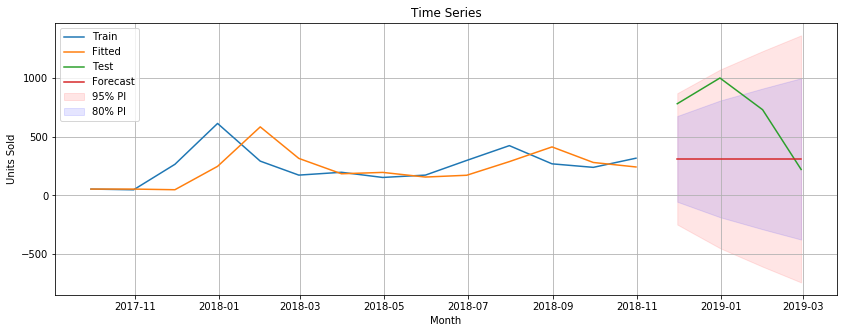

In [37]:
Model= SimpleExpSmoothing(train).fit(smoothing_level=ALPHA,optimized=False)
Forecast= Model.forecast(len(test))
residual=test.values-Forecast.values
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label='Fitted')
plt.plot(test,label="Test")
plt.plot(test.index,Forecast,label="Forecast")
high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% PI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% PI",color="blue")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()

In [38]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 25043.15
RMSE: 158.25
MAE: 115.49
MASE: 1.01
**************************************** Test Results ****************************************
MSE: 219801.32
RMSE: 468.83
MAE: 416.99
MASE: 3.23


#### 1.1.2 Holts Linear

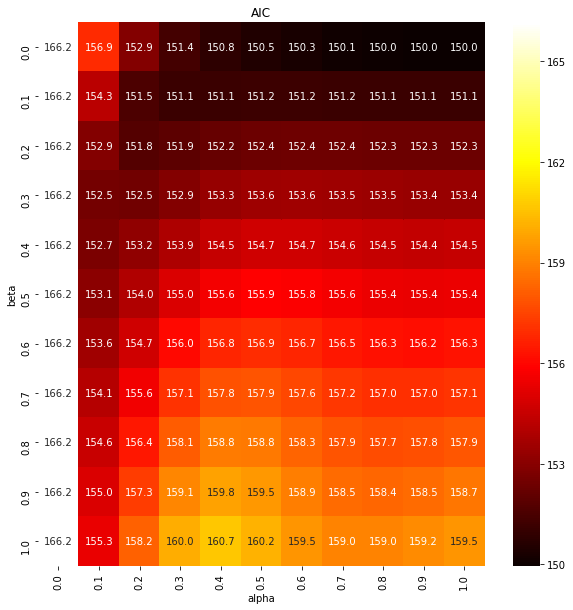

149.9522015244873

In [39]:
alpha = beta = np.arange(0,1.1,0.1)
train_error=[]    

for alpha_i in alpha:
    for beta_i in beta:
        Model= Holt(train).fit(smoothing_level=alpha_i, smoothing_slope=beta_i, optimized=False)
        #Forecast= Model.forecast(len(test))
        #et=Fast_trend_product[30:]-Model.fittedfcast[30:-1]
        #MSE=sum(et**2)/len(et)
        train_error.append(Model.aic)

fig ,ax= plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

scores=np.array(train_error).reshape(len(alpha),len(beta)).T
sns.heatmap(scores,annot=True, cmap=plt.cm.hot, fmt='.1f')
plt.xticks(ticks=np.arange(0,len(alpha))+0.5,labels=np.round(alpha,1),rotation='90')
plt.yticks(ticks=np.arange(0,len(beta))+0.5,labels=np.round(beta,1),rotation='90')
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title('AIC')
plt.show()
scores.min()

In [40]:
ALPHA=0.8
BETA=0.1

1. <p>As we have already seen the inconsistency of the series being stationary when tested with train set and series (some series are like this) being showing trend with entire series, we can also observe here that the beta which is a slope smoothing constant is too low.</p>
2. <p>We can infer that trend in entire series not considerable but there is trend.</p>

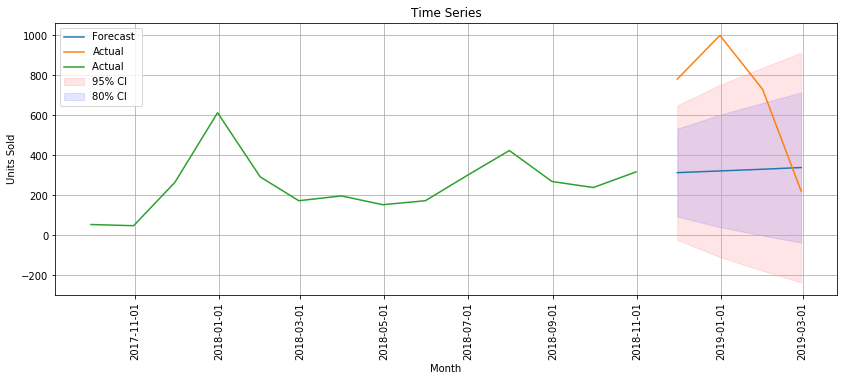

In [41]:
Model= Holt(train).fit(smoothing_level=ALPHA, smoothing_slope=BETA, optimized=False)
Forecast= Model.forecast(len(test))
residual=train[1:]-Model.fittedfcast[1:-1]
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)

plt.plot(test.index,Forecast,label="Forecast ")
plt.plot(test.index,test,label="Actual")
plt.plot(train,label="Actual ")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% CI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% CI",color="blue")

plt.xticks(rotation='90')

plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [42]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 27511.46
RMSE: 165.87
MAE: 122.95
MASE: 1.07
**************************************** Test Results ****************************************
MSE: 212999.95
RMSE: 461.52
MAE: 415.8
MASE: 3.22


#### 1.1.3 ARIMA

In [43]:
test_trend_stationarity(Fast_trend_product)

False

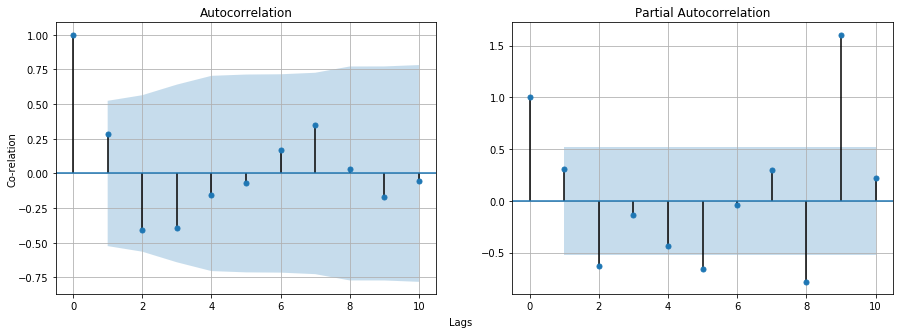

In [44]:
plot_acf_pacf(train,10)
#ARIMA_pd(Fast_trend_product)

((2, 0, 0), 243.81)

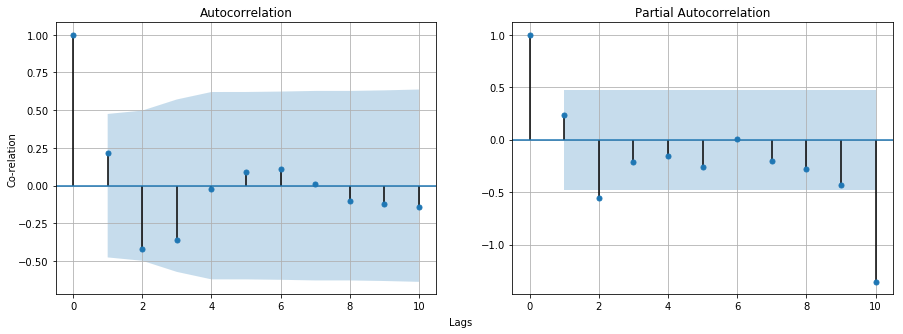

In [45]:
plot_acf_pacf(np.diff(Fast_trend_product),10)
ARIMA_GridSearch(Fast_trend_product)

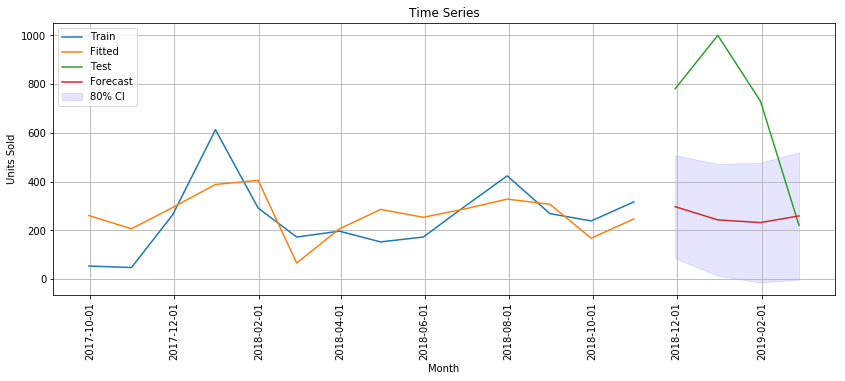

In [46]:
Model= ARIMA(train,order = (2,0,0))
Model = Model.fit()
Forecast= Model.forecast(len(test),alpha=0.05)
%matplotlib inline
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label="Fitted")
plt.plot(test.index,test,label="Test")
plt.plot(test.index,Forecast[0],label="Forecast")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.fill_between(test.index,Forecast[2].T[0],Forecast[2].T[1],alpha=0.1,label="80% CI",color="blue")
plt.xticks(rotation='90')
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [47]:
ytrain=train.values[1:]
ytest=test.values
ft_test=Forecast[0]
ft_train=Model.fittedvalues[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=ytest-ft_test
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([3,'ARIMA(2,0,0)','--','--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([3,'ARIMA(2,0,0)','--','--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 22862.09
RMSE: 151.2
MAE: 128.67
MASE: 1.05
**************************************** Test Results ****************************************
MSE: 263905.59
RMSE: 513.72
MAE: 444.14
MASE: 3.72


In [48]:
print("\t"*2,"Summary of All Models Results:\n")
print("\t"*3,"Train Results:")
print(pt_train,'\n')
print("\t"*3,"Test Results:")
print(pt_test)

		 Summary of All Models Results:

			 Train Results:
+--------+----------------+-------+------+----------+--------+--------+------+
| Sr. No |     Model      | alpha | beta |   MSE    |  RMSE  |  MAE   | MASE |
+--------+----------------+-------+------+----------+--------+--------+------+
|   1    |      SES       |  0.92 |  --  | 25043.15 | 158.25 | 115.49 | 1.01 |
|   2    | Holt's Linear  |  0.8  | 0.1  | 27511.46 | 165.87 | 122.95 | 1.07 |
|   3    |  ARIMA(2,0,0)  |   --  |  --  | 22862.09 | 151.2  | 128.67 | 1.05 |
+--------+----------------+-------+------+----------+--------+--------+------+ 

			 Test Results:
+--------+----------------+-------+------+-----------+--------+--------+------+
| Sr. No |     Model      | alpha | beta |    MSE    |  RMSE  |  MAE   | MASE |
+--------+----------------+-------+------+-----------+--------+--------+------+
|   1    |      SES       |  0.92 |  --  | 219801.32 | 468.83 | 416.99 | 3.23 |
|   2    | Holt's Linear  |  0.8  | 0.1  | 212999.95 

Basis the accuracy of train and test results anyone of SES and hotl's linear can be used to forecast the yeezy_ss_data. Will choose SES as forecasting method.

#### 1.2 Off-White Brand wise

In [49]:
OS,FS,IS,DS=slow_fast(offwhite_ss_data)
print('No of obsolescence risk shoe size series',len(OS))
print('No of Fast Moving shoe size series',len(FS))
print('No of Intermittence shoe size series',len(IS))
print('No of Dead shoe size series',len(DS))

No of obsolescence risk shoe size series 0
No of Fast Moving shoe size series 21
No of Intermittence shoe size series 0
No of Dead shoe size series 0


All in this also are Fast has fast movinf series hence same methods are applicable for this too.

In [50]:
# Further classification
Fast_stationary=[]
Fast_trend=[]
for i in FS:
    if(test_trend_stationarity(offwhite_ss_data[i])):
        Fast_stationary.append(i)
    else:
        Fast_trend.append(i)

In [51]:
print("Fast Moving shoe_size which are stationary:\n")
for i in np.arange(0,len(Fast_stationary)):
    print("\t\t",i+1,Fast_stationary[i])
print("Fast Moving shoe_size which are non stationary:\n")
for i in np.arange(0,len(Fast_trend)):
    print("\t\t",i+1,Fast_trend[i])

Fast Moving shoe_size which are stationary:

		 1 9.0
Fast Moving shoe_size which are non stationary:

		 1 4.0
		 2 4.5
		 3 5.0
		 4 5.5
		 5 6.0
		 6 6.5
		 7 7.0
		 8 7.5
		 9 8.0
		 10 8.5
		 11 9.5
		 12 10.0
		 13 10.5
		 14 11.0
		 15 11.5
		 16 12.0
		 17 12.5
		 18 13.0
		 19 14.0
		 20 15.0


In [52]:
Fast_trend = FS
Fast_trend_product=offwhite_ss_data[Fast_trend[14]]

In [53]:
pt_final= PrettyTable()
pt_final.field_names=['Sr. No.','Demand Pattern','Model','alpha','beta']

In [54]:
from prettytable import PrettyTable
pt_train=PrettyTable()
pt_train.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']
pt_test=PrettyTable()
pt_test.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']

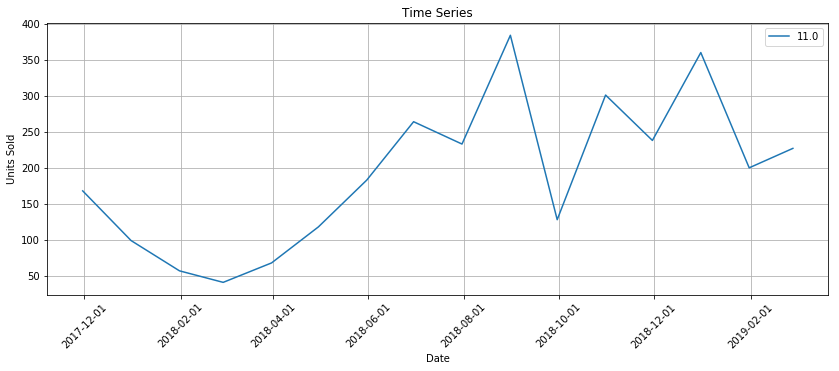

In [55]:
plot_time_series(Fast_trend_product)

In [56]:
train,test=train_test_split(Fast_trend_product)

In [57]:
test_trend_stationarity(train)

False

This shows that the training data is not stationary but the whole data before train test split was stationary
Hence we would apply Fast moving trend methods to all the yeezy_ss_data. Methods are mentioned below :

1. SES
2. Holt's linear
2. ARIMA

##### 1.2.1 SES

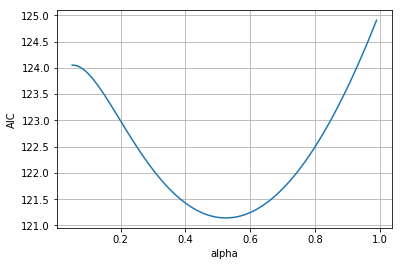

The Least AIC has been achieved for alpha=0.52 with MSE = 121.14


In [58]:
train_aic=[]
alpha_t=np.arange(0.05,1,0.01)
for alpha in alpha_t:
    Model= SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
    #Forecast= Model.forecast(len(test))
    #et=test-Forecast
    #MSE=sum(et**2)/len(et)
    train_aic.append(Model.aic)
plt.plot(alpha_t,train_aic)
plt.xlabel("alpha")
plt.ylabel("AIC")
plt.grid()
plt.show()
print("The Least AIC has been achieved for alpha={} with MSE = {}".format(np.round(alpha_t[np.argmin(train_aic)],2),np.round(min(train_aic),2)))
ALPHA=np.round(alpha_t[np.argmin(train_aic)],2)

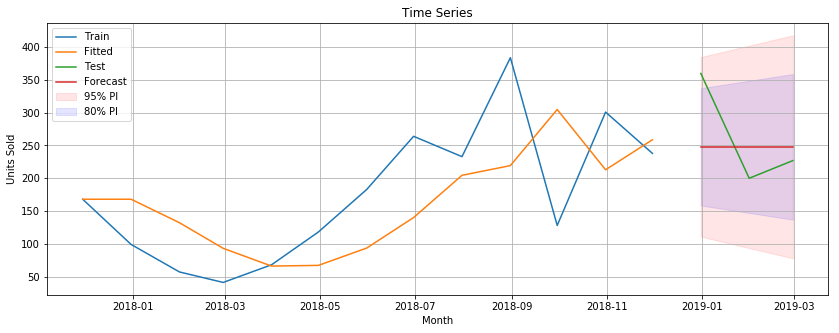

In [59]:
Model= SimpleExpSmoothing(train).fit(smoothing_level=ALPHA,optimized=False)
Forecast= Model.forecast(len(test))
residual=test.values-Forecast.values
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label='Fitted')
plt.plot(test,label="Test")
plt.plot(test.index,Forecast,label="Forecast")
high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% PI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% PI",color="blue")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()

In [60]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 8193.0
RMSE: 90.52
MAE: 72.42
MASE: 0.99
**************************************** Test Results ****************************************
MSE: 5097.75
RMSE: 71.4
MAE: 60.32
MASE: 0.43


#### 1.2.2 Holts Linear

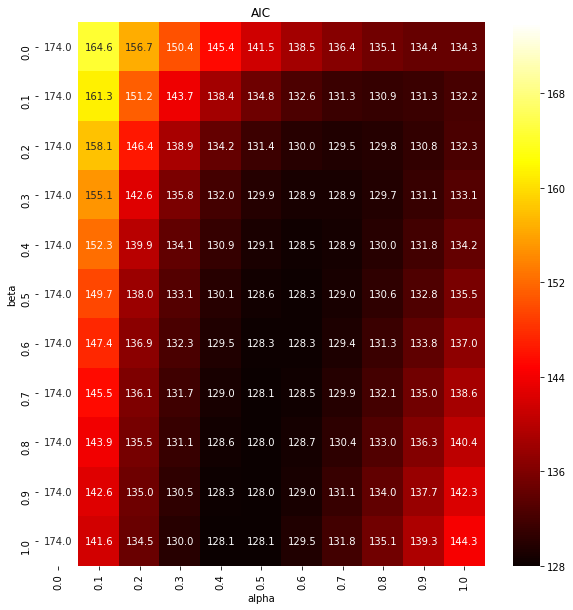

In [61]:
alpha = beta = np.arange(0,1.1,0.1)
train_error=[]    

for alpha_i in alpha:
    for beta_i in beta:
        Model= Holt(train).fit(smoothing_level=alpha_i, smoothing_slope=beta_i, optimized=False)
        #Forecast= Model.forecast(len(test))
        #et=Fast_trend_product[30:]-Model.fittedfcast[30:-1]
        #MSE=sum(et**2)/len(et)
        train_error.append(Model.aic)

fig ,ax= plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

scores=np.array(train_error).reshape(len(alpha),len(beta)).T
sns.heatmap(scores,annot=True, cmap=plt.cm.hot, fmt='.1f')
plt.xticks(ticks=np.arange(0,len(alpha))+0.5,labels=np.round(alpha,1),rotation='90')
plt.yticks(ticks=np.arange(0,len(beta))+0.5,labels=np.round(beta,1),rotation='90')
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title('AIC')
plt.show()

In [62]:
ALPHA=0.5
BETA=0.8

1. <p>As we have already seen the inconsistency of the series being stationary when tested with train set and series being showing trend with entire series, we can also observe here that the beta which is a slope smoothing constant is too low.</p>
2. <p>We can infer that trend in entire series not considerable but there is trend.</p>

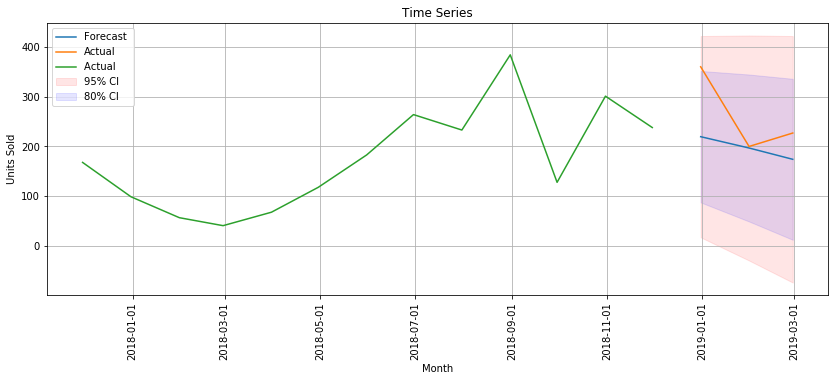

In [63]:
Model= Holt(train).fit(smoothing_level=ALPHA, smoothing_slope=BETA, optimized=False)
Forecast= Model.forecast(len(test))
residual=train[1:]-Model.fittedfcast[1:-1]
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)

plt.plot(test.index,Forecast,label="Forecast ")
plt.plot(test.index,test,label="Actual")
plt.plot(train,label="Actual ")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% CI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% CI",color="blue")

plt.xticks(rotation='90')

plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [64]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 10191.79
RMSE: 100.95
MAE: 69.96
MASE: 0.88
**************************************** Test Results ****************************************
MSE: 7499.35
RMSE: 86.6
MAE: 65.41
MASE: 0.35


#### 1.2.3 ARIMA

In [65]:
test_trend_stationarity(Fast_trend_product)

False

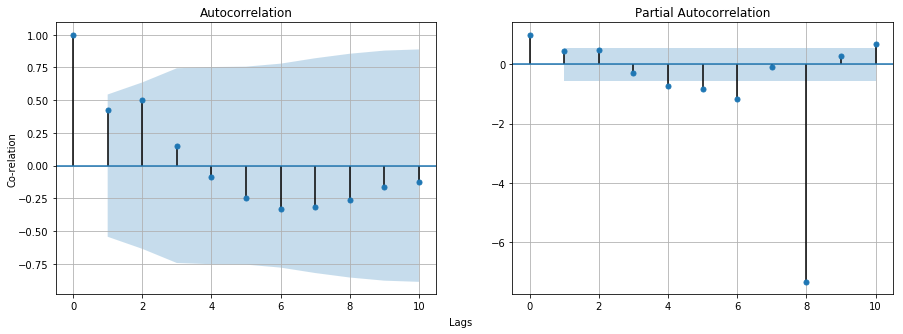

In [66]:
plot_acf_pacf(train,10)
#ARIMA_pd(Fast_trend_product)

((0, 0, 2), 193.03)

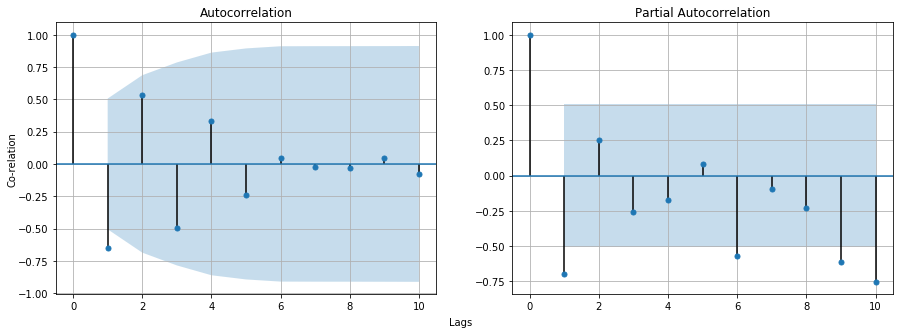

In [67]:
plot_acf_pacf(np.diff(Fast_trend_product),10)
ARIMA_GridSearch(Fast_trend_product)

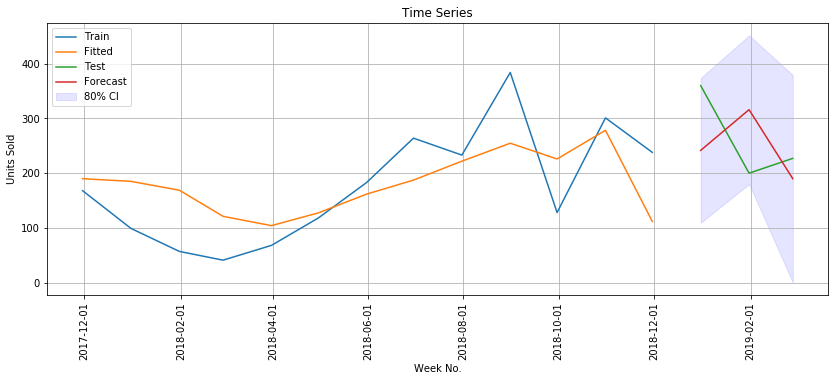

In [68]:
Model= ARIMA(train,order = (0,0,2))
Model = Model.fit()
Forecast= Model.forecast(len(test),alpha=0.05)
%matplotlib inline
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label="Fitted")
plt.plot(test.index,test,label="Test")
plt.plot(test.index,Forecast[0],label="Forecast")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.fill_between(test.index,Forecast[2].T[0],Forecast[2].T[1],alpha=0.1,label="80% CI",color="blue")
plt.xticks(rotation='90')
plt.xlabel("Week No.")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [69]:
ytrain=train.values[1:]
ytest=test.values
ft_test=Forecast[0]
ft_train=Model.fittedvalues[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=ytest-ft_test
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([3,'ARIMA(0,0,2)','--','--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([3,'ARIMA(0,0,2)','--','--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 9104.11
RMSE: 95.42
MAE: 85.14
MASE: 1.02
**************************************** Test Results ****************************************
MSE: 9617.68
RMSE: 98.07
MAE: 90.5
MASE: 0.92


In [70]:
print("\t"*2,"Summary of All Models Results:\n")
print("\t"*3,"Train Results:")
print(pt_train,'\n')
print("\t"*3,"Test Results:")
print(pt_test)

		 Summary of All Models Results:

			 Train Results:
+--------+----------------+-------+------+----------+--------+-------+------+
| Sr. No |     Model      | alpha | beta |   MSE    |  RMSE  |  MAE  | MASE |
+--------+----------------+-------+------+----------+--------+-------+------+
|   1    |      SES       |  0.52 |  --  |  8193.0  | 90.52  | 72.42 | 0.99 |
|   2    | Holt's Linear  |  0.5  | 0.8  | 10191.79 | 100.95 | 69.96 | 0.88 |
|   3    |  ARIMA(0,0,2)  |   --  |  --  | 9104.11  | 95.42  | 85.14 | 1.02 |
+--------+----------------+-------+------+----------+--------+-------+------+ 

			 Test Results:
+--------+----------------+-------+------+---------+-------+-------+------+
| Sr. No |     Model      | alpha | beta |   MSE   |  RMSE |  MAE  | MASE |
+--------+----------------+-------+------+---------+-------+-------+------+
|   1    |      SES       |  0.52 |  --  | 5097.75 |  71.4 | 60.32 | 0.43 |
|   2    | Holt's Linear  |  0.5  | 0.8  | 7499.35 |  86.6 | 65.41 | 0.35 |


##### Conclusion - These results shows that SES is best to forecast for shoe size time series for both brands

### 2. Region wise

#### 2.1 Yeezy Brand

In [71]:
OS,FS,IS,DS=slow_fast(yeezy_br_data)
print('No of obsolescence risk shoe sizes data',len(OS))
print('No of Fast Moving shoe sizes data',len(FS))
print('No of Intermittence shoe sizes data',len(IS))
print('No of Dead shoe sizes data',len(DS))

No of obsolescence risk shoe sizes data 0
No of Fast Moving shoe sizes data 48
No of Intermittence shoe sizes data 3
No of Dead shoe sizes data 0


##### As only three foloows intermittent demand and will not be a good idea to develov another model for hence concidering all as fast movinng

In [72]:
# Further classification
FS = yeezy_br_data.columns
Fast_stationary=[]
Fast_trend=[]
for i in FS:
    if(test_trend_stationarity(yeezy_br_data[i])):
        Fast_stationary.append(i)
    else:
        Fast_trend.append(i)

In [73]:
print("Fast Moving shoe_size which are stationary:\n")
for i in np.arange(0,len(Fast_stationary)):
    print("\t\t",i+1,Fast_stationary[i])
print("Fast Moving shoe_size which are non stationary:\n")
for i in np.arange(0,len(Fast_trend)):
    print("\t\t",i+1,Fast_trend[i])

Fast Moving shoe_size which are stationary:

Fast Moving shoe_size which are non stationary:

		 1 Alabama
		 2 Alaska
		 3 Arizona
		 4 Arkansas
		 5 California
		 6 Colorado
		 7 Connecticut
		 8 Delaware
		 9 District of Columbia
		 10 Florida
		 11 Georgia
		 12 Hawaii
		 13 Idaho
		 14 Illinois
		 15 Indiana
		 16 Iowa
		 17 Kansas
		 18 Kentucky
		 19 Louisiana
		 20 Maine
		 21 Maryland
		 22 Massachusetts
		 23 Michigan
		 24 Minnesota
		 25 Mississippi
		 26 Missouri
		 27 Montana
		 28 Nebraska
		 29 Nevada
		 30 New Hampshire
		 31 New Jersey
		 32 New Mexico
		 33 New York
		 34 North Carolina
		 35 North Dakota
		 36 Ohio
		 37 Oklahoma
		 38 Oregon
		 39 Pennsylvania
		 40 Rhode Island
		 41 South Carolina
		 42 South Dakota
		 43 Tennessee
		 44 Texas
		 45 Utah
		 46 Vermont
		 47 Virginia
		 48 Washington
		 49 West Virginia
		 50 Wisconsin
		 51 Wyoming


All are fast moving with non stationarity hence we would be considering them in fast moving trend

In [74]:
# Fast moving
yeezy_br_data[FS].head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Order Date,,,,,,,,,,,,,,,,,,,,,
2017-09-30,6,0.0,3,0.0,94,11,5,2,0.0,35,...,0.0,3,41,0.0,0.0,15,12,1,8,1
2017-10-31,2,0.0,6,1.0,112,12,9,1,2.0,39,...,0.0,3,20,0.0,2.0,9,19,2,3,0
2017-11-30,17,1.0,50,5.0,714,29,49,18,9.0,208,...,2.0,28,180,9.0,2.0,90,68,4,30,1
2017-12-31,26,5.0,80,7.0,1346,71,90,38,15.0,397,...,4.0,38,464,34.0,3.0,141,144,9,50,0
2018-01-31,16,4.0,57,8.0,641,32,44,15,7.0,238,...,5.0,24,213,19.0,4.0,75,67,6,28,3


In [75]:
Fast_trend = FS
Fast_trend_product=yeezy_br_data[Fast_trend[3]]

In [76]:
pt_final= PrettyTable()
pt_final.field_names=['Sr. No.','Demand Pattern','Model','alpha','beta']

In [77]:
from prettytable import PrettyTable
pt_train=PrettyTable()
pt_train.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']
pt_test=PrettyTable()
pt_test.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']

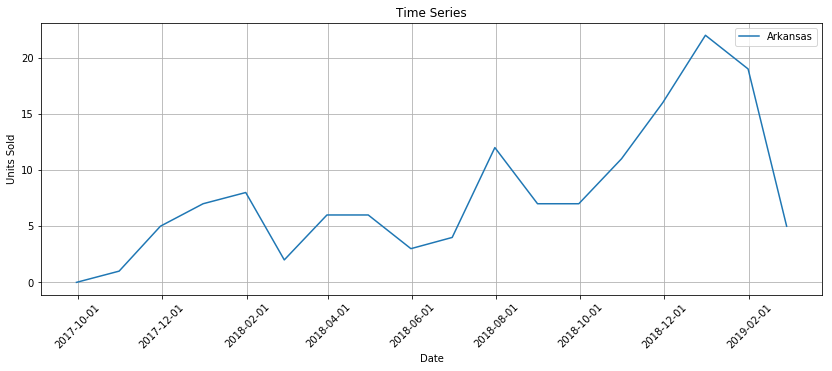

In [78]:
Fast_trend
plot_time_series(Fast_trend_product)

In [79]:
train,test=train_test_split(Fast_trend_product)

In [80]:
test_trend_stationarity(train)

False

#### 2.1.1 SES

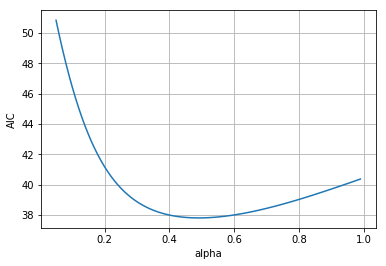

The Least AIC has been achieved for alpha=0.49 with MSE = 37.79


In [81]:
train_aic=[]
alpha_t=np.arange(0.05,1,0.01)
for alpha in alpha_t:
    Model= SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
    #Forecast= Model.forecast(len(test))
    #et=test-Forecast
    #MSE=sum(et**2)/len(et)
    train_aic.append(Model.aic)
plt.plot(alpha_t,train_aic)
plt.xlabel("alpha")
plt.ylabel("AIC")
plt.grid()
plt.show()
print("The Least AIC has been achieved for alpha={} with MSE = {}".format(np.round(alpha_t[np.argmin(train_aic)],2),np.round(min(train_aic),2)))
ALPHA=np.round(alpha_t[np.argmin(train_aic)],2)

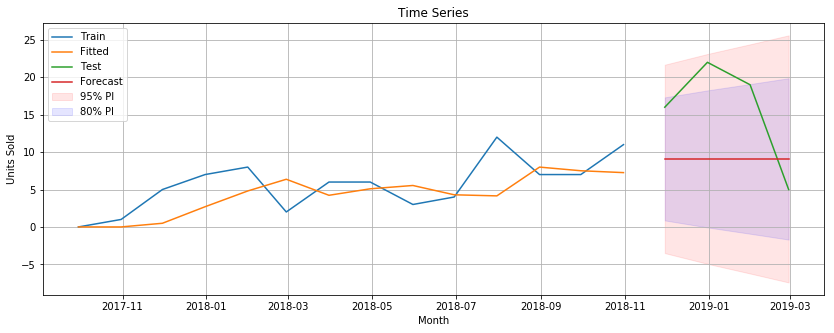

In [82]:
Model= SimpleExpSmoothing(train).fit(smoothing_level=ALPHA,optimized=False)
Forecast= Model.forecast(len(test))
residual=test.values-Forecast.values
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label='Fitted')
plt.plot(test,label="Test")
plt.plot(test.index,Forecast,label="Forecast")
high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% PI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% PI",color="blue")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()

In [83]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 11.18
RMSE: 3.34
MAE: 2.57
MASE: 0.95
**************************************** Test Results ****************************************
MSE: 82.31
RMSE: 9.07
MAE: 8.45
MASE: 3.07


#### 2.1.2 Holt's Linear

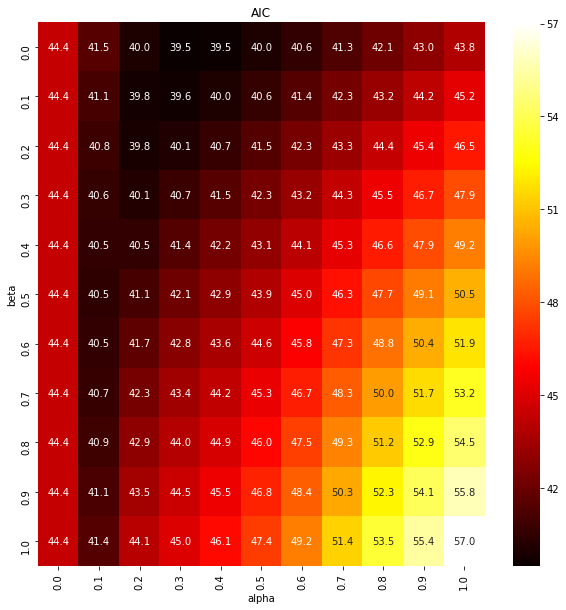

In [84]:
alpha = beta = np.arange(0,1.1,0.1)
train_error=[]    

for alpha_i in alpha:
    for beta_i in beta:
        Model= Holt(train).fit(smoothing_level=alpha_i, smoothing_slope=beta_i, optimized=False)
        #Forecast= Model.forecast(len(test))
        #et=Fast_trend_product[30:]-Model.fittedfcast[30:-1]
        #MSE=sum(et**2)/len(et)
        train_error.append(Model.aic)

fig ,ax= plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

scores=np.array(train_error).reshape(len(alpha),len(beta)).T
sns.heatmap(scores,annot=True, cmap=plt.cm.hot, fmt='.1f')
plt.xticks(ticks=np.arange(0,len(alpha))+0.5,labels=np.round(alpha,1),rotation='90')
plt.yticks(ticks=np.arange(0,len(beta))+0.5,labels=np.round(beta,1),rotation='90')
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title('AIC')
plt.show()

In [85]:
ALPHA=0.1
BETA=0.3

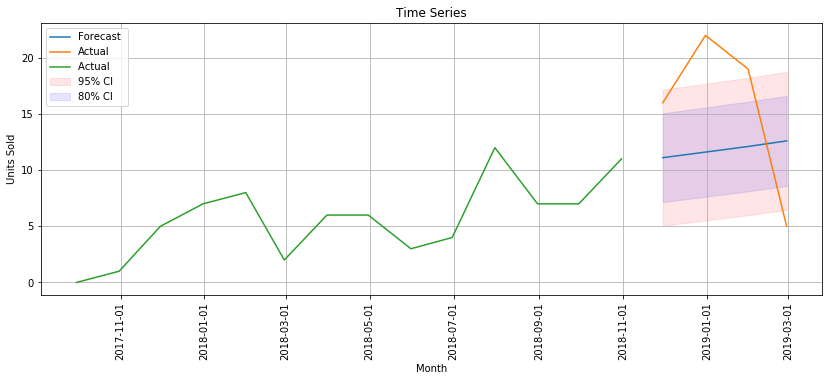

In [86]:
Model= Holt(train).fit(smoothing_level=ALPHA, smoothing_slope=BETA, optimized=False)
Forecast= Model.forecast(len(test))
residual=train[1:]-Model.fittedfcast[1:-1]
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)

plt.plot(test.index,Forecast,label="Forecast ")
plt.plot(test.index,test,label="Actual")
plt.plot(train,label="Actual ")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% CI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% CI",color="blue")

plt.xticks(rotation='90')

plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [87]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 10.29
RMSE: 3.21
MAE: 2.79
MASE: 1.0
**************************************** Test Results ****************************************
MSE: 59.33
RMSE: 7.7
MAE: 7.45
MASE: 2.84


#### 2.1.3. ARIMA

In [88]:
test_trend_stationarity(Fast_trend_product)

False

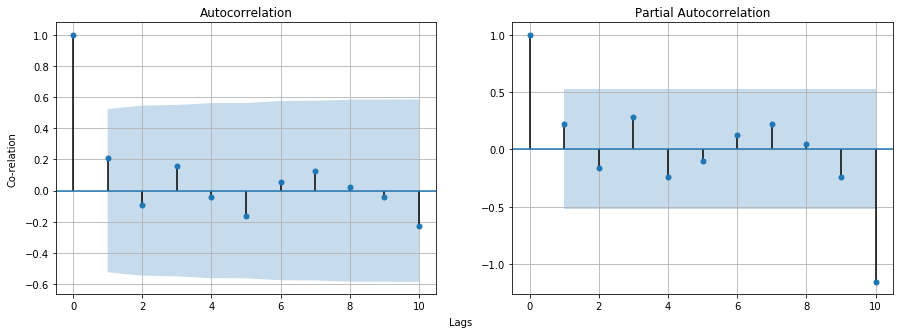

In [89]:
plot_acf_pacf(train,10)

(0, 1, 0)

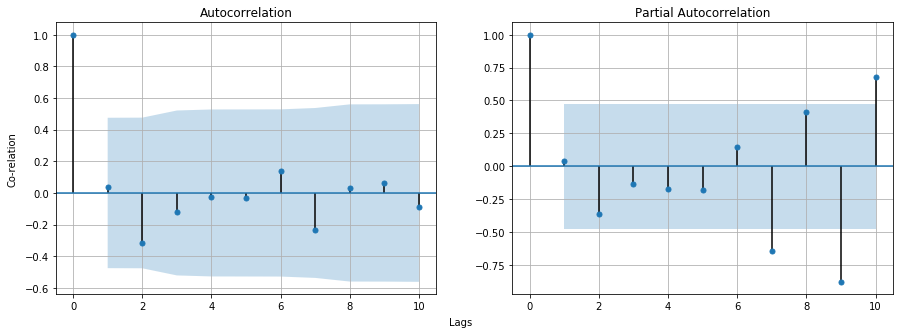

In [90]:
plot_acf_pacf(np.diff(Fast_trend_product),10)
ARIMA_pd(Fast_trend_product)

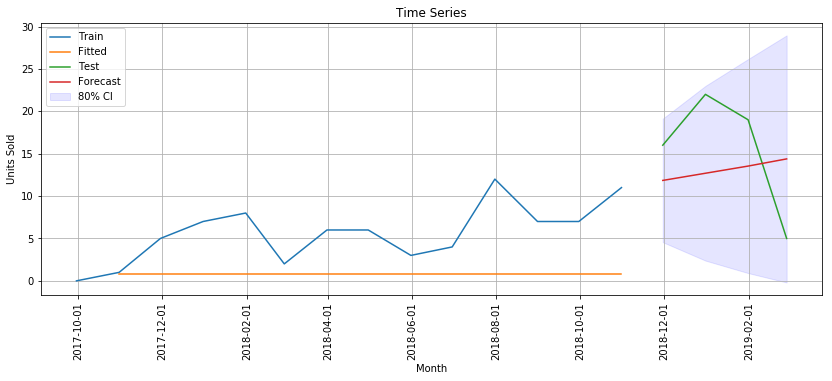

In [91]:
Model= ARIMA(train,order = (0,1,0))
Model = Model.fit()
Forecast= Model.forecast(len(test),alpha=0.05)
%matplotlib inline
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label="Fitted")
plt.plot(test.index,test,label="Test")
plt.plot(test.index,Forecast[0],label="Forecast")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.fill_between(test.index,Forecast[2].T[0],Forecast[2].T[1],alpha=0.1,label="80% CI",color="blue")
plt.xticks(rotation='90')
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [92]:
ytrain=train.values[1:]
ytest=test.values
ft_test=Forecast[0]
ft_train=Model.fittedvalues


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=ytest-ft_test
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([3,'ARIMA(1,0,1)','--','--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([3,'ARIMA(1,0,1)','--','--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 36.82
RMSE: 6.07
MAE: 5.23
MASE: 2.0
**************************************** Test Results ****************************************
MSE: 55.45
RMSE: 7.45
MAE: 7.08
MASE: 2.84


In [93]:
print("\t"*2,"Summary of All Models Results:\n")
print("\t"*3,"Train Results:")
print(pt_train,'\n')
print("\t"*3,"Test Results:")
print(pt_test)

		 Summary of All Models Results:

			 Train Results:
+--------+----------------+-------+------+-------+------+------+------+
| Sr. No |     Model      | alpha | beta |  MSE  | RMSE | MAE  | MASE |
+--------+----------------+-------+------+-------+------+------+------+
|   1    |      SES       |  0.49 |  --  | 11.18 | 3.34 | 2.57 | 0.95 |
|   2    | Holt's Linear  |  0.1  | 0.3  | 10.29 | 3.21 | 2.79 | 1.0  |
|   3    |  ARIMA(1,0,1)  |   --  |  --  | 36.82 | 6.07 | 5.23 | 2.0  |
+--------+----------------+-------+------+-------+------+------+------+ 

			 Test Results:
+--------+----------------+-------+------+-------+------+------+------+
| Sr. No |     Model      | alpha | beta |  MSE  | RMSE | MAE  | MASE |
+--------+----------------+-------+------+-------+------+------+------+
|   1    |      SES       |  0.49 |  --  | 82.31 | 9.07 | 8.45 | 3.07 |
|   2    | Holt's Linear  |  0.1  | 0.3  | 59.33 | 7.7  | 7.45 | 2.84 |
|   3    |  ARIMA(1,0,1)  |   --  |  --  | 55.45 | 7.45 | 7.08

#### 2.2 Off-WHite Brand

In [94]:
OS,FS,IS,DS=slow_fast(offwhite_br_data)
print('No of obsolescence risk shoe sizes data',len(OS))
print('No of Fast Moving shoe sizes data',len(FS))
print('No of Intermittence shoe sizes data',len(IS))
print('No of Dead shoe sizes data',len(DS))

No of obsolescence risk shoe sizes data 0
No of Fast Moving shoe sizes data 37
No of Intermittence shoe sizes data 5
No of Dead shoe sizes data 0


In [95]:
# Further classification
FS = offwhite_br_data.columns
Fast_stationary=[]
Fast_trend=[]
for i in FS:
    if(test_trend_stationarity(offwhite_br_data[i])):
        Fast_stationary.append(i)
    else:
        Fast_trend.append(i)

In [96]:
print("Fast Moving shoe_size which are stationary:\n")
for i in np.arange(0,len(Fast_stationary)):
    print("\t\t",i+1,Fast_stationary[i])
print("Fast Moving shoe_size which are non stationary:\n")
for i in np.arange(0,len(Fast_trend)):
    print("\t\t",i+1,Fast_trend[i])

Fast Moving shoe_size which are stationary:

		 1 California
		 2 Indiana
		 3 Oregon
Fast Moving shoe_size which are non stationary:

		 1 Alabama
		 2 Arizona
		 3 Arkansas
		 4 Colorado
		 5 Connecticut
		 6 Delaware
		 7 District of Columbia
		 8 Florida
		 9 Georgia
		 10 Hawaii
		 11 Illinois
		 12 Iowa
		 13 Kansas
		 14 Kentucky
		 15 Louisiana
		 16 Maine
		 17 Maryland
		 18 Massachusetts
		 19 Michigan
		 20 Minnesota
		 21 Missouri
		 22 Nebraska
		 23 Nevada
		 24 New Hampshire
		 25 New Jersey
		 26 New Mexico
		 27 New York
		 28 North Carolina
		 29 Ohio
		 30 Oklahoma
		 31 Pennsylvania
		 32 Rhode Island
		 33 South Carolina
		 34 Tennessee
		 35 Texas
		 36 Utah
		 37 Virginia
		 38 Washington
		 39 Wisconsin


In [97]:
# Fast moving
offwhite_br_data[FS].head()

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,Oregon,Pennsylvania,Rhode Island,South Carolina,Tennessee,Texas,Utah,Virginia,Washington,Wisconsin
Order Date,,,,,,,,,,,,,,,,,,,,,
2017-09-30,1,3,1,49,3,4,1,0.0,9,2,...,3,2,1,1,1,8,1,4,1,2
2017-10-31,0,1,0,29,1,1,6,0.0,4,0,...,0,5,0,0,0,7,1,2,2,2
2017-11-30,10,20,0,373,22,15,22,7.0,80,26,...,39,34,5,9,1,74,6,28,28,10
2017-12-31,0,7,3,228,3,10,3,3.0,55,23,...,21,31,1,2,5,53,5,18,17,8
2018-01-31,2,10,1,130,9,12,4,4.0,32,8,...,12,14,1,4,4,26,4,8,6,3


In [98]:
Fast_trend = FS
Fast_trend_product=offwhite_br_data[Fast_trend[9]]
Fast_trend[9]

'Georgia'

In [99]:
pt_final= PrettyTable()
pt_final.field_names=['Sr. No.','Demand Pattern','Model','alpha','beta']

In [100]:
from prettytable import PrettyTable
pt_train=PrettyTable()
pt_train.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']
pt_test=PrettyTable()
pt_test.field_names=['Sr. No','Model','alpha','beta','MSE','RMSE','MAE','MASE']

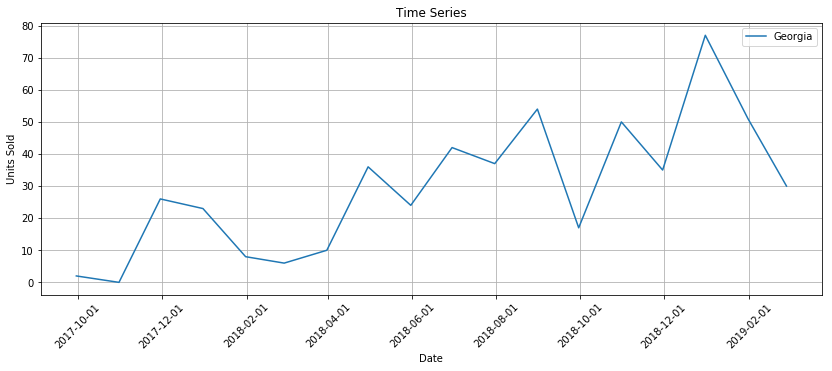

In [101]:
Fast_trend
plot_time_series(Fast_trend_product)

In [102]:
train,test=train_test_split(Fast_trend_product)

In [103]:
test_trend_stationarity(train)

False

#### 2.2.1 SES

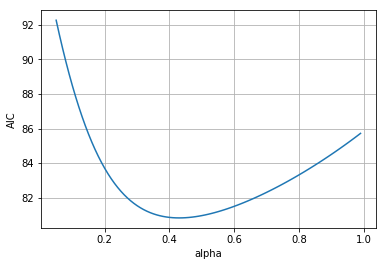

The Least AIC has been achieved for alpha=0.43 with MSE = 80.83


In [104]:
train_aic=[]
alpha_t=np.arange(0.05,1,0.01)
for alpha in alpha_t:
    Model= SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
    #Forecast= Model.forecast(len(test))
    #et=test-Forecast
    #MSE=sum(et**2)/len(et)
    train_aic.append(Model.aic)
plt.plot(alpha_t,train_aic)
plt.xlabel("alpha")
plt.ylabel("AIC")
plt.grid()
plt.show()
print("The Least AIC has been achieved for alpha={} with MSE = {}".format(np.round(alpha_t[np.argmin(train_aic)],2),np.round(min(train_aic),2)))
ALPHA=np.round(alpha_t[np.argmin(train_aic)],2)

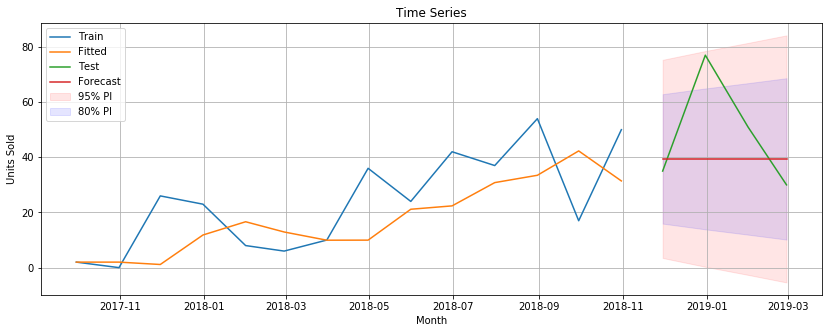

In [105]:
Model= SimpleExpSmoothing(train).fit(smoothing_level=ALPHA,optimized=False)
Forecast= Model.forecast(len(test))
residual=test.values-Forecast.values
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label='Fitted')
plt.plot(test,label="Test")
plt.plot(test.index,Forecast,label="Forecast")
high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% PI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% PI",color="blue")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()

In [106]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([1,'SES',ALPHA,'--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 241.75
RMSE: 15.55
MAE: 12.34
MASE: 0.87
**************************************** Test Results ****************************************
MSE: 413.83
RMSE: 20.34
MAE: 15.75
MASE: 1.28


#### 2. Holt's Linear

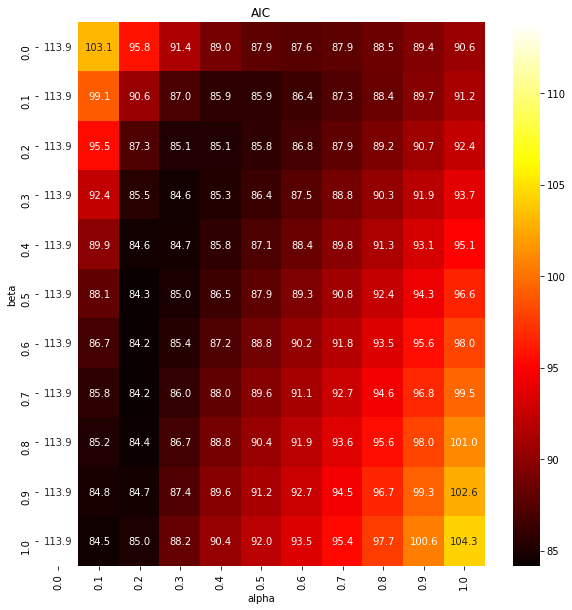

In [107]:
alpha = beta = np.arange(0,1.1,0.1)
train_error=[]    

for alpha_i in alpha:
    for beta_i in beta:
        Model= Holt(train).fit(smoothing_level=alpha_i, smoothing_slope=beta_i, optimized=False)
        train_error.append(Model.aic)

fig ,ax= plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

scores=np.array(train_error).reshape(len(alpha),len(beta)).T
sns.heatmap(scores,annot=True, cmap=plt.cm.hot, fmt='.1f')
plt.xticks(ticks=np.arange(0,len(alpha))+0.5,labels=np.round(alpha,1),rotation='90')
plt.yticks(ticks=np.arange(0,len(beta))+0.5,labels=np.round(beta,1),rotation='90')
plt.xlabel("alpha")
plt.ylabel("beta")
plt.title('AIC')
plt.show()

In [108]:
ALPHA=0.2
BETA=0.7

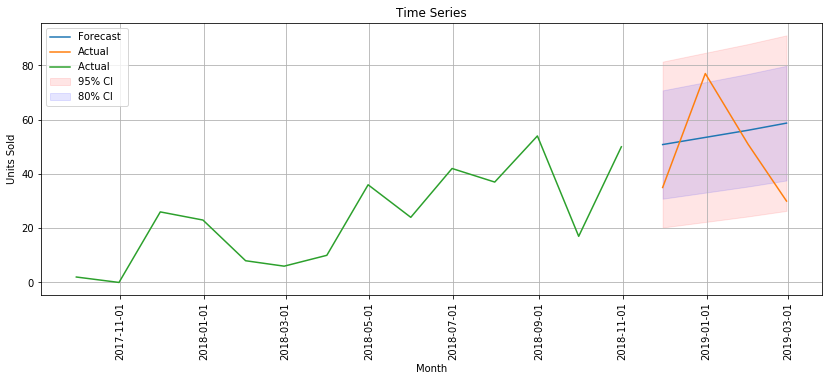

In [109]:
Model= Holt(train).fit(smoothing_level=ALPHA, smoothing_slope=BETA, optimized=False)
Forecast= Model.forecast(len(test))
residual=train[1:]-Model.fittedfcast[1:-1]
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)

plt.plot(test.index,Forecast,label="Forecast ")
plt.plot(test.index,test,label="Actual")
plt.plot(train,label="Actual ")
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

high95,low95=prediction_interval(residual,Forecast,ALPHA,1.96,len(test))
high80,low80=prediction_interval(residual,Forecast,ALPHA,1.28,len(test))
plt.fill_between(test.index,high95,low95,alpha=0.1,label="95% CI",color="red")
plt.fill_between(test.index,high80,low80,alpha=0.1,label="80% CI",color="blue")

plt.xticks(rotation='90')

plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [110]:
ytrain=train.values
ytest=test.values
ft_test=Forecast
ft_train=Model.fittedfcast[:-1]


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=(ytest-ft_test).values
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([2,"Holt's Linear ",ALPHA,BETA,MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 231.46
RMSE: 15.21
MAE: 11.1
MASE: 0.77
**************************************** Test Results ****************************************
MSE: 413.9
RMSE: 20.34
MAE: 18.3
MASE: 1.26


#### 2.2.3 ARIMA

In [111]:
test_trend_stationarity(Fast_trend_product)

False

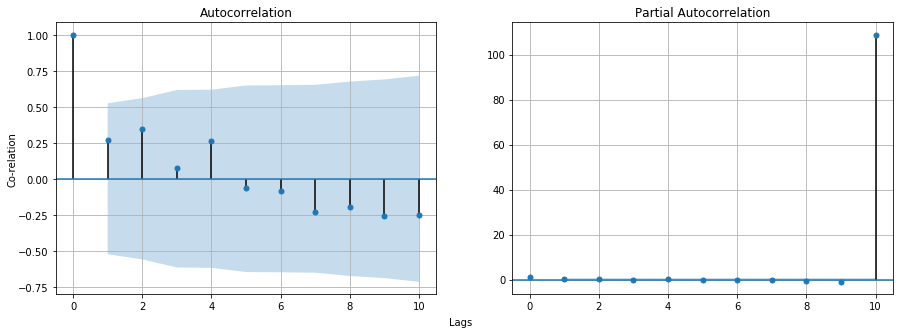

In [112]:
plot_acf_pacf(train,10)

(1, 1, 1)

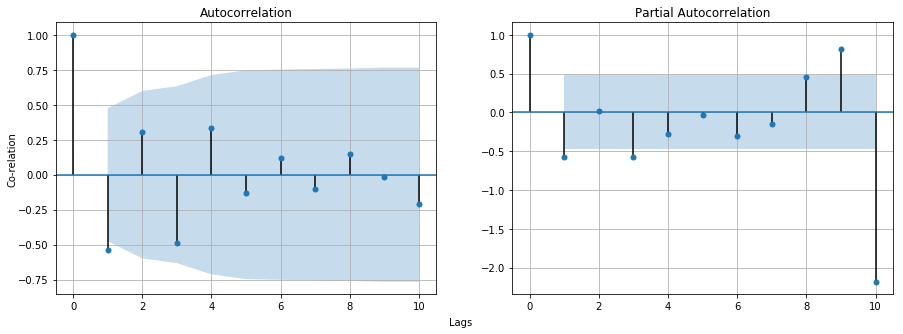

In [113]:
plot_acf_pacf(np.diff(Fast_trend_product),10)
ARIMA_pd(Fast_trend_product)

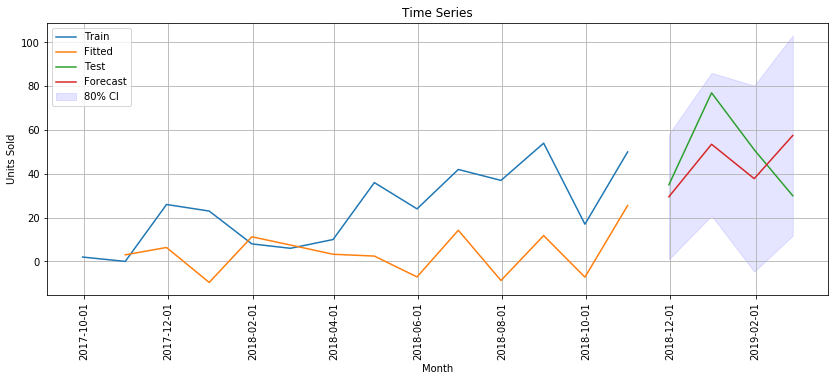

In [114]:
Model= ARIMA(train,order = (1,1,1))
Model = Model.fit()
Forecast= Model.forecast(len(test),alpha=0.05)
%matplotlib inline
fig ,ax= plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.plot(train,label="Train")
plt.plot(Model.fittedvalues,label="Fitted")
plt.plot(test.index,test,label="Test")
plt.plot(test.index,Forecast[0],label="Forecast")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1,interval=2))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.fill_between(test.index,Forecast[2].T[0],Forecast[2].T[1],alpha=0.1,label="80% CI",color="blue")
plt.xticks(rotation='90')
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.title("Time Series")
plt.legend(loc=2)
plt.grid()
plt.show()
plt.show()

In [115]:
ytrain=train.values[1:]
ytest=test.values
ft_test=Forecast[0]
ft_train=Model.fittedvalues


et_in_sample=ytrain-ft_train
yt=ytrain
et_out_sample=ytest-ft_test
MASE_train,MASE_test=Mean_Absolute_Scaled_Error(yt,et_in_sample,et_out_sample)



MSE,RMSE,MAE=Forecast_Measures(ytrain,ft_train)
print("*"*40,"Train Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_train,2))
pt_train.add_row([3,'ARIMA(1,1,1)','--','--',MSE,RMSE,MAE,np.round(MASE_train,2)])

MSE,RMSE,MAE=Forecast_Measures(ytest,ft_test)
print("*"*40,"Test Results","*"*40)
print('MSE:',MSE)
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MASE:',np.round(MASE_test,2))
pt_test.add_row([3,'ARIMA(1,1,1)','--','--',MSE,RMSE,MAE,np.round(MASE_test,2)])

**************************************** Train Results ****************************************
MSE: 725.55
RMSE: 26.94
MAE: 22.74
MASE: 1.7
**************************************** Test Results ****************************************
MSE: 378.3
RMSE: 19.45
MAE: 17.42
MASE: 1.49


In [116]:
print("\t"*2,"Summary of All Models Results:\n")
print("\t"*3,"Train Results:")
print(pt_train,'\n')
print("\t"*3,"Test Results:")
print(pt_test)

		 Summary of All Models Results:

			 Train Results:
+--------+----------------+-------+------+--------+-------+-------+------+
| Sr. No |     Model      | alpha | beta |  MSE   |  RMSE |  MAE  | MASE |
+--------+----------------+-------+------+--------+-------+-------+------+
|   1    |      SES       |  0.43 |  --  | 241.75 | 15.55 | 12.34 | 0.87 |
|   2    | Holt's Linear  |  0.2  | 0.7  | 231.46 | 15.21 |  11.1 | 0.77 |
|   3    |  ARIMA(1,1,1)  |   --  |  --  | 725.55 | 26.94 | 22.74 | 1.7  |
+--------+----------------+-------+------+--------+-------+-------+------+ 

			 Test Results:
+--------+----------------+-------+------+--------+-------+-------+------+
| Sr. No |     Model      | alpha | beta |  MSE   |  RMSE |  MAE  | MASE |
+--------+----------------+-------+------+--------+-------+-------+------+
|   1    |      SES       |  0.43 |  --  | 413.83 | 20.34 | 15.75 | 1.28 |
|   2    | Holt's Linear  |  0.2  | 0.7  | 413.9  | 20.34 |  18.3 | 1.26 |
|   3    |  ARIMA(1,1,1)  

SES is best to forecast all the time series.

# Forecasting Model:

### Preprocessing and arranging data

In [117]:
# Read file -
# Importing data set
data=pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name="Raw Data")

# Number of months to be forecasted
h=6


# Brand wise bifurcation
data_yeezy = data[data.Brand == 'Yeezy']
data_offwhite = data[data.Brand == 'Off-White']

## Brand wise and show size wise time series

# for yeezy brand
yeezy_ss_data = pd.DataFrame()
for i in shoe_size:
    temp = data_yeezy[data_yeezy['Shoe Size']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        yeezy_ss_data[i] = temp
        

# for offwite brand
offwhite_ss_data = pd.DataFrame()
for i in shoe_size:
    temp = data_offwhite[data_offwhite['Shoe Size']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        offwhite_ss_data[i] = temp


# Replacing all the NaN values with 0
yeezy_ss_data.fillna(0, inplace=True)
offwhite_ss_data.fillna(0, inplace=True)


# brand wise and region wise
# for yeezy brand
yeezy_br_data = pd.DataFrame()
for i in buyer_regions:
    temp = data_yeezy[data_yeezy['Buyer Region']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        yeezy_br_data[i] = temp
        

# for offwite brand
offwhite_br_data = pd.DataFrame()
for i in buyer_regions:
    temp = data_offwhite[data_offwhite['Buyer Region']==i].groupby(pd.Grouper(key='Order Date', freq='1M')).count().iloc[:,1]
    if np.count_nonzero(temp)>=13:
        offwhite_br_data[i] = temp


# Replacing all the NaN values with 0
yeezy_br_data.fillna(0, inplace=True)
offwhite_br_data.fillna(0, inplace=True)

### Yeezy Brand Shoe Size wise forecast

In [118]:
# Forecasting for yeezy brand all shoe sizes

shoe_size = list(yeezy_ss_data.columns)

# Hyper parameter values
Alpha_yeezy_ss_data = 0.92
Prediction_Interval=1.28


# Assgning values to list
#Index = []
Brand_name = []
Shoe_Size = []
Forecast_value = []
Low = []
High = []
Month = []

for i in range(len(yeezy_ss_data.columns)):
    Model= SimpleExpSmoothing(yeezy_ss_data[shoe_size[i]]).fit(smoothing_level=Alpha_yeezy_ss_data,optimized=False)
    Forecast= np.round(list(Model.forecast(h)))
    #print(np.round(Forecast))
    high,low=prediction_interval(Model.fittedvalues.values-yeezy_ss_data[shoe_size[i]].values,Forecast,Alpha_yeezy_ss_data,Prediction_Interval,h)
    high=np.round(high)
    low=np.round(low)
    #Index. Append(i)
    for j in range(6):
        Brand_name.append('Yeezy')
        Shoe_Size.append(shoe_size[i])
        Month.append(j+1)
    Forecast_value.append(Forecast)
    High.append(high)
    Low.append(low)

FORECAST_VALUE = []
LOW = []
HIGH = []

for i in range(23):
    for j in range(6):
        LOW.append(Low[i][j])
        HIGH.append(High[i][j])
        FORECAST_VALUE.append(Forecast_value[i][j])
   
# Addding values to dataframe
Forecast_data=pd.DataFrame({'Month':Month,'Brand_name':Brand_name,'Shoe_Size':Shoe_Size,'Forecast_value':FORECAST_VALUE,'Low':LOW,'High':HIGH})
Forecast_data.to_csv('Yeezy_Shoe_Size_Wise_Forecast.csv', index=False)

### Off-White Shoe Size Wise

In [119]:
# Forecasting for yeezy brand all shoe sizes

shoe_size = list(offwhite_ss_data.columns)

# Hyper parameter values
Alpha_offwhite_ss_data = 0.52
Prediction_Interval=1.28


# Assgning values to list
#Index = []
Brand_name = []
Shoe_Size = []
Forecast_value = []
Low = []
High = []
Month = []

for i in range(len(offwhite_ss_data.columns)):
    Model= SimpleExpSmoothing(offwhite_ss_data[shoe_size[i]]).fit(smoothing_level=Alpha_offwhite_ss_data,optimized=False)
    Forecast= np.round(list(Model.forecast(h)))
    #print(np.round(Forecast))
    high,low=prediction_interval(Model.fittedvalues.values-offwhite_ss_data[shoe_size[i]].values,Forecast,Alpha_offwhite_ss_data,Prediction_Interval,h)
    high=np.round(high)
    low=np.round(low)
    #Index. Append(i)
    for j in range(6):
        Brand_name.append('Off-White')
        Shoe_Size.append(shoe_size[i])
        Month.append(j+1)
    Forecast_value.append(Forecast)
    High.append(high)
    Low.append(low)

FORECAST_VALUE = []
LOW = []
HIGH = []

for i in range(21):
    for j in range(6):
        LOW.append(Low[i][j])
        HIGH.append(High[i][j])
        FORECAST_VALUE.append(Forecast_value[i][j])
   
# Addding values to dataframe
Forecast_data=pd.DataFrame({'Month':Month,'Brand_name':Brand_name,'Shoe_Size':Shoe_Size,'Forecast_value':FORECAST_VALUE,'Low':LOW,'High':HIGH})
Forecast_data.to_csv('Off_White_Shoe_Size_Wise_Forecast.csv', index=False)

### Yeezy Buyer Region Wise

In [120]:
# Forecasting for yeezy brand all buyer regions

buyer_region = list(yeezy_br_data.columns)

# Hyper parameter values
Alpha_yeezy_br_data = 0.49
Prediction_Interval=1.28


# Assgning values to list
#Index = []
Brand_name = []
Buyer_Region = []
Forecast_value = []
Low = []
High = []
Month = []

for i in range(len(yeezy_br_data.columns)):
    Model= SimpleExpSmoothing(yeezy_br_data[buyer_region[i]]).fit(smoothing_level=Alpha_yeezy_br_data,optimized=True)
    Forecast= np.round(list(Model.forecast(h)))
    #print(np.round(Forecast))
    high,low=prediction_interval(Model.fittedvalues.values-yeezy_br_data[buyer_region[i]].values,Forecast,Alpha_yeezy_br_data,Prediction_Interval,h)
    high=np.round(high)
    low=np.round(low)
    #Index. Append(i)
    for j in range(6):
        Brand_name.append('Yeezy')
        Buyer_Region.append(buyer_region[i])
        Month.append(j+1)
    Forecast_value.append(Forecast)
    High.append(high)
    Low.append(low)

FORECAST_VALUE = []
LOW = []
HIGH = []

for i in range(51):
    for j in range(6):
        LOW.append(Low[i][j])
        HIGH.append(High[i][j])
        FORECAST_VALUE.append(Forecast_value[i][j])
   
# Addding values to dataframe
Forecast_data=pd.DataFrame({'Month':Month,'Brand_name':Brand_name,'Buyer_Region':Buyer_Region,'Forecast_value':FORECAST_VALUE,'Low':LOW,'High':HIGH})
Forecast_data.to_csv('Yeezy_Buyer_Region_Wise_Forecast.csv', index=False)

### Off-White Buyer Region Wise

In [121]:
# Forecasting for yeezy brand all buyer regions

buyer_region = list(offwhite_br_data.columns)

# Hyper parameter values
Alpha_offwhite_br_data = 0.43
Prediction_Interval=1.28


# Assgning values to list
#Index = []
Brand_name = []
Buyer_Region = []
Forecast_value = []
Low = []
High = []
Month = []

for i in range(len(offwhite_br_data.columns)):
    Model= SimpleExpSmoothing(offwhite_br_data[buyer_region[i]]).fit(smoothing_level=Alpha_offwhite_br_data,optimized=False)
    Forecast= np.round(list(Model.forecast(h)))
    #print(np.round(Forecast))
    high,low=prediction_interval(Model.fittedvalues.values-offwhite_br_data[buyer_region[i]].values,Forecast,Alpha_offwhite_br_data,Prediction_Interval,h)
    high=np.round(high)
    low=np.round(low)
    #Index. Append(i)
    for j in range(6):
        Brand_name.append('Yeezy')
        Buyer_Region.append(buyer_region[i])
        Month.append(j+1)
    Forecast_value.append(Forecast)
    High.append(high)
    Low.append(low)

FORECAST_VALUE = []
LOW = []
HIGH = []

for i in range(42):
    for j in range(6):
        LOW.append(Low[i][j])
        HIGH.append(High[i][j])
        FORECAST_VALUE.append(Forecast_value[i][j])
   
# Addding values to dataframe
Forecast_data=pd.DataFrame({'Month':Month,'Brand_name':Brand_name,'Buyer_Region':Buyer_Region,'Forecast_value':FORECAST_VALUE,'Low':LOW,'High':HIGH})
Forecast_data.to_csv('Off_White_Buyer_Region_Wise_Forecast.csv', index=False)